# _*Using Grover's Algorithm to Perform Quantum Search*_

This notebook demonstrates how to use the `Qiskit Algorithms` library `Grover` search algorithm and process the result.

In [16]:
import numpy as np
import os
import tempfile

from qiskit.circuit.library.phase_oracle import PhaseOracle
from qiskit.visualization import plot_histogram
from qiskit.primitives import Sampler

from qiskit_algorithms import Grover
from qiskit_algorithms import AmplificationProblem


## Use Quantum Search to Find Solutions to 3-SAT Problems

Let's look at an example 3-Satisfiability (3-SAT) problem and walkthrough how we can use Quantum Search to find its satisfying solutions. 3-SAT problems are usually expressed in [Conjunctive Normal Forms (CNF)](https://en.wikipedia.org/wiki/Conjunctive_normal_form) and written in the [DIMACS-CNF](https://www.satcompetition.org/2009/format-benchmarks2009.html) format. For example:

In [2]:
input_3sat_instance = '''
c example DIMACS-CNF 3-SAT
p cnf 3 5
-1 -2 -3 0
1 -2 3 0
1 2 -3 0
1 -2 -3 0
-1 2 3 0
'''

The CNF of this 3-SAT instance contains 3 variables and 5 clauses:

$(\neg v_1 \vee \neg v_2 \vee \neg v_3) \wedge (v_1 \vee \neg v_2 \vee v_3) \wedge (v_1 \vee v_2 \vee \neg v_3) \wedge (v_1 \vee \neg v_2 \vee \neg v_3) \wedge (\neg v_1 \vee v_2 \vee v_3)$

It can be verified that this 3-SAT problem instance has three satisfying solutions:

$(v_1, v_2, v_3) = (T, F, T)$ or $(F, F, F)$ or $(T, T, F)$

Or, expressed using the DIMACS notation:

`1 -2 3`, or `-1 -2 -3`, or `1 2 -3`.

With this example problem input, we then create the corresponding `oracle` for our `Grover` search. In particular, we use the `PhaseOracle` component provided by qiskit-algorithms, which supports parsing DIMACS-CNF format strings and constructing the corresponding oracle circuit.

In [3]:
fp = tempfile.NamedTemporaryFile(mode="w+t", delete=False)
fp.write(input_3sat_instance)
file_name = fp.name
fp.close()
oracle = None
try:
    oracle = PhaseOracle.from_dimacs_file(file_name)
except ImportError as ex:
    print(ex)
finally:
    os.remove(file_name)

The `oracle` can now be used to create an Grover instance:

In [5]:
problem = None
if oracle is not None:
    problem = AmplificationProblem(oracle, is_good_state=oracle.evaluate_bitstring)

We can then configure the backend and run the Grover instance to get the result:

In [12]:
grover = Grover(sampler=Sampler())
result = None
if problem is not None:
    result = grover.amplify(problem)
    print(result.assignment)

011


/tmp/ipykernel_19433/1165858065.py:1: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  grover = Grover(sampler=Sampler())


As seen above, a satisfying solution to the specified 3-SAT problem is obtained. And it is indeed one of the three satisfying solutions.

Since we used the Sampler, the complete measurement result is also returned, as shown in the plot below, where it can be seen that the binary strings 000, 011, and 101 (note the bit order in each string), corresponding to the three satisfying solutions all have high probabilities associated with them.

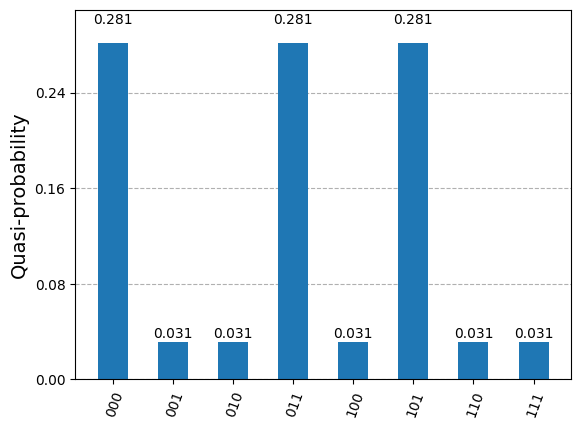

In [14]:
plot_histogram(result.circuit_results[0])

## Quantum Search with Arbitrary Boolean Logical Expressions

`Grover` can also be used to perform Quantum Search on `Oracle` constructed from means in addition to DIMACS. For example, the `PhaseOracle` can actually be configured using arbitrary Boolean logical expressions, as demonstrated below.

/tmp/ipykernel_19433/982990536.py:5: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  grover = Grover(sampler=Sampler())


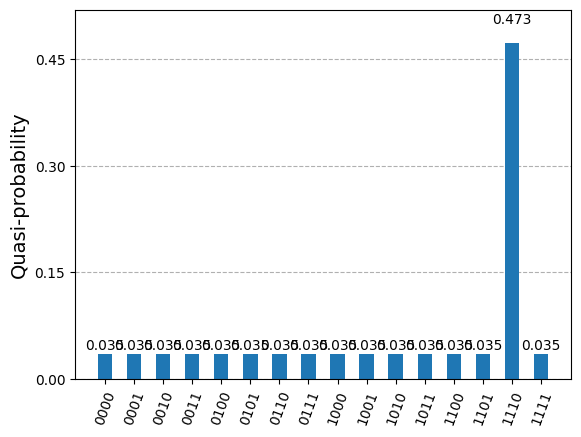

In [15]:
expression = "(w ^ x) & ~(y ^ z) & (x & y & z)"

oracle = PhaseOracle(expression)
problem = AmplificationProblem(oracle, is_good_state=oracle.evaluate_bitstring)
grover = Grover(sampler=Sampler())
result = grover.amplify(problem)
plot_histogram(result.circuit_results[0])

In the example above, the input Boolean logical expression `'(w ^ x) & ~(y ^ z) & (x & y & z)'` should be quite self-explanatory, where `^`, `~`, and `&` represent the Boolean logical XOR, NOT, and AND operators, respectively. It should be quite easy to figure out the satisfying solution by examining its parts: `w ^ x` calls for `w` and `x` taking different values; `~(y ^ z)` requires `y` and `z` be the same; `x & y & z` dictates all three to be `True`. Putting these together, we get the satisfying solution `(w, x, y, z) = (False, True, True, True)`, which our `Grover`'s result agrees with.

## Quantum Search with Oracles from TruthTable (deprecated)

With Aqua, `Oracle`s can also be constructed from truth tables, meaning we can also perform Quantum Search on truth tables. Even though this might seem like a moot point as we would be essentially searching for entries of a truth table with the $1$ value, it'd a good example for demonstrative purpose.

In [8]:
truthtable = '1000000000000001'

As shown, the `truthtable` is specified with a bitstring containing values of all entries in the table. It has length $16$, so the corresponding truth table is of $4$ input bits. Since the very first and last values are $1$, the corresponding truth table target entries are `0000` and `1111`.

Next, we can setup the `Oracle` and `Grover` objects to perform Quantum Search as usual.

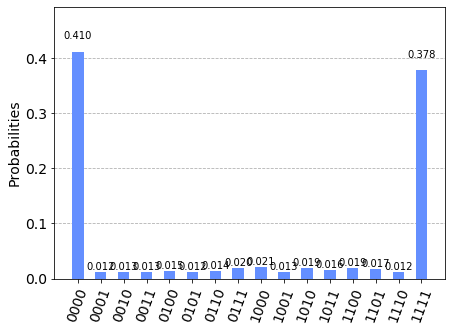

In [9]:
oracle = TruthTableOracle(truthtable)
grover = Grover(oracle)
result = grover.run(QuantumInstance(BasicAer.get_backend('qasm_simulator'), shots=1024))
plot_histogram(result['measurement'])

As shown, the search result coincides with our expectation.